# Clustering for Transaction Classification

This notebook covers use cases where your data is unlabelled but has features that can be used to cluster them into meaningful categories. The challenge with clustering is making the features that make those clusters stand out human-readable, and that is where we'll look to use GPT-3 to generate meaningful cluster descriptions for us. We can then use these to apply labels to a previously unlabelled dataset.

To feed the model we use embeddings created using the approach displayed in the notebook [Multiclass classification for transactions Notebook](Multiclass_classification_for_transactions.ipynb), applied to the full 359 transactions in the dataset to give us a bigger pool for learning

## Setup

In [1]:
# optional env import
from dotenv import load_dotenv
load_dotenv()

True

In [18]:
# imports
 
from openai import OpenAI
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import os
from ast import literal_eval

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))
COMPLETIONS_MODEL = "gpt-3.5-turbo"

# This path leads to a file with data and precomputed embeddings
embedding_path = "data/library_transactions_with_embeddings_359.csv"


## Clustering

We'll reuse the approach from the [Clustering Notebook](Clustering.ipynb), using K-Means to cluster our dataset using the feature embeddings we created previously. We'll then use the Completions endpoint to generate cluster descriptions for us and judge their effectiveness

In [13]:
df = pd.read_csv(embedding_path)
df.head()

,Date,Supplier,Description,Transaction value (£),combined,n_tokens,embedding
0,21/04/2016,M & J Ballantyne Ltd,George IV Bridge Work,35098.0,Supplier: M & J Ballantyne Ltd; Description: G...,118,"[-0.013169967569410801, -0.004833734128624201,..."
1,26/04/2016,Private Sale,Literary & Archival Items,30000.0,Supplier: Private Sale; Description: Literary ...,114,"[-0.019571533426642418, -0.010801066644489765,..."
2,30/04/2016,City Of Edinburgh Council,Non Domestic Rates,40800.0,Supplier: City Of Edinburgh Council; Descripti...,114,"[-0.0054041435942053795, -6.548957026097924e-0..."
3,09/05/2016,Computacenter Uk,Kelvin Hall,72835.0,Supplier: Computacenter Uk; Description: Kelvi...,113,"[-0.004776035435497761, -0.005533686839044094,..."
4,09/05/2016,John Graham Construction Ltd,Causewayside Refurbishment,64361.0,Supplier: John Graham Construction Ltd; Descri...,117,"[0.003290407592430711, -0.0073441751301288605,..."


In [5]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["embedding"] = embedding_df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(359, 1536)

In [6]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

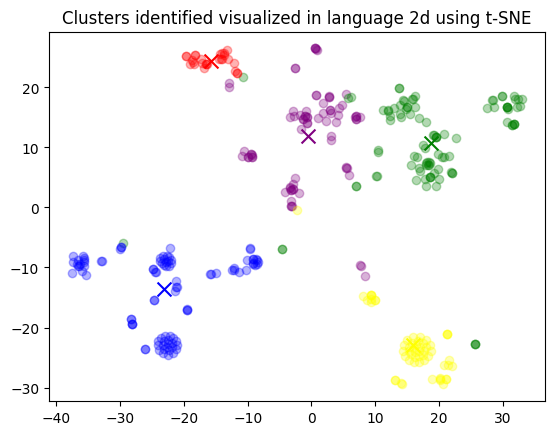

In [7]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [30]:
# We'll read 10 transactions per cluster as we're expecting some variation
transactions_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:\n")

    transactions = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined.str.replace("Supplier: ", "")
        .str.replace("Description: ", ":  ")
        .str.replace("Value: ", ":  ")
        .sample(transactions_per_cluster, random_state=42)
        .values
    )
    response = client.chat.completions.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        messages=[
            {"role": "user",
             "content": f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. 
                What do the following transactions have in common?\n\nTransactions:\n"""\n{transactions}\n"""\n\nTheme:'''}
        ],
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content.replace("\n", ""))
    print("\n")

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    for j in range(transactions_per_cluster):
        print(sample_cluster_rows.Supplier.values[j], end=", ")
        print(sample_cluster_rows.Description.values[j], end="\n")

    print("-" * 100)
    print("\n")


Cluster 0 Theme:

The common theme among these transactions is that they all involve spending money on various expenses such as electricity, non-domestic rates, IT equipment, computer equipment, and the purchase of an electric van.


EDF ENERGY, Electricity Oct 2019 3 buildings
City Of Edinburgh Council, Non Domestic Rates 
EDF, Electricity
EX LIBRIS, IT equipment
City Of Edinburgh Council, Non Domestic Rates 
CITY OF EDINBURGH COUNCIL, Rates for 33 Salisbury Place
EDF Energy, Electricity
XMA Scotland Ltd, IT equipment
Computer Centre UK Ltd, Computer equipment
ARNOLD CLARK, Purchase of an electric van
----------------------------------------------------------------------------------------------------


Cluster 1 Theme:

The common theme among these transactions is that they all involve payments for various goods and services. Some specific examples include student bursary costs, collection of papers, architectural works, legal deposit services, papers related to Alisdair Gray, resourc

### Conclusion

We now have five new clusters that we can use to describe our data. Looking at the visualisation some of our clusters have some overlap and we'll need some tuning to get to the right place, but already we can see that GPT-3 has made some effective inferences. In particular, it picked up that items including legal deposits were related to literature archival, which is true but the model was given no clues on. Very cool, and with some tuning we can create a base set of clusters that we can then use with a multiclass classifier to generalise to other transactional datasets we might use.